In [1]:
print("Hiran N MM21B030")

Hiran N MM21B030


In [1]:
import wandb

wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mm21b030 (mm21b030-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.7764271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47332823..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.6631372].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.7764271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.7142857].


Found 10 classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

Total images: 9999
Train images: 7999 (80.0%)
Val images: 2000 (20.0%)


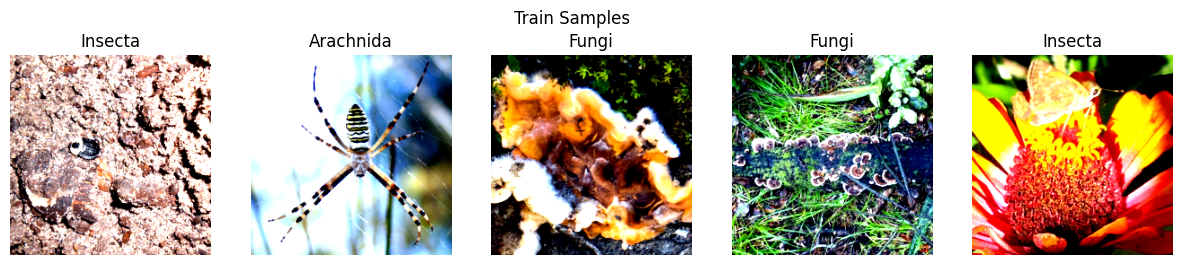

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.490453..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.5742297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.4446442].


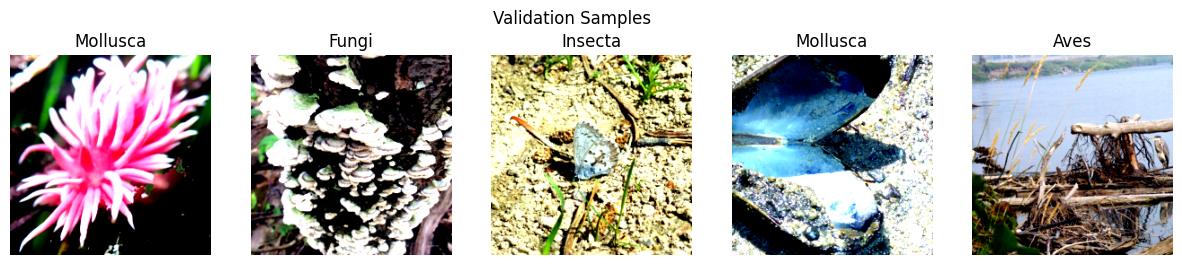

In [1]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 1. Get class names
data_dir = "./inaturalist_12K/train"
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f"Found {len(class_names)} classes: {class_names}")

# 2. Create dataset class
class INaturalistDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        return self.transform(img), label

# 3. Load paths and labels
image_paths = []
labels = []
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_idx)

# 4. Create train/val split
combined = list(zip(image_paths, labels))
random.shuffle(combined)
split_idx = int(0.8 * len(combined))
train_data = combined[:split_idx]
val_data = combined[split_idx:]

# 5. Create datasets and dataloaders
train_dataset = INaturalistDataset(
    [x[0] for x in train_data],
    [x[1] for x in train_data]
)
val_dataset = INaturalistDataset(
    [x[0] for x in val_data],
    [x[1] for x in val_data]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"\nTotal images: {len(combined)}")
print(f"Train images: {len(train_dataset)} ({len(train_dataset)/len(combined):.1%})")
print(f"Val images: {len(val_dataset)} ({len(val_dataset)/len(combined):.1%})")

# 6. Visualize samples
def visualize_samples(dataset, title, n_samples=5):
    indices = random.sample(range(len(dataset)), n_samples)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(f"{class_names[label]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_samples(train_dataset, "Train Samples")
visualize_samples(val_dataset, "Validation Samples")

In [36]:
import gc
import torch

# Delete all variables
for obj in list(globals()):
    if isinstance(globals()[obj], torch.Tensor) or isinstance(globals()[obj], torch.nn.Module):
        del globals()[obj]

# Run garbage collection
gc.collect()
torch.cuda.empty_cache()  # Clear PyTorch cache

In [11]:
import importlib
import model  # Your module name (without .py)

# Reload the module
importlib.reload(model)
from model import CustomCNN
import torch

model = CustomCNN(
    input_shape=(3, 224, 224),
    num_classes=10,
    filters=[32, 64, 128, 256, 512],
    kernel_sizes=[3, 3, 3, 3, 3],
    activations=['relu', 'leaky_relu', 'relu', 'leaky_relu', 'relu'],
    dense_neurons=128,
    dense_activation='relu',
    dropout_rates=[0.1, 0.1, 0.2, 0.2, 0.3],
    use_batchnorm=True,
    pool_sizes=[2, 2, 2, 2, 2]
)


# Train
model.train_model(train_loader, val_loader,
                    batch_size=8, epochs=1, device='cuda')



Epoch 1/1: 100%|██████████| 250/250 [00:28<00:00,  8.68it/s, loss=2.17, acc=14.5]



Epoch 1/1 - Train Loss: 2.5586 - Train Acc: 14.50% - Val Loss: 2.2773 - Val Acc: 14.60%


In [2]:
import wandb
from model import CustomCNN 
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets  # <-- Add this import
# Assuming your model class is named CustomCNN

# Correct sweep configuration
sweep_config = {
    "name": "CNN_Sweep_v1",
    "method": "grid",  # Alternatives: "random" or "bayes"
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {
            "values": [5]
        },
        "filters": {
            "values": [
                [32, 32, 32, 32, 32], [8, 16, 32, 64, 128], [128, 64, 32, 16, 8]
            ]
        },
        "activations": {
            "values": [
                ['relu']*5, ['silu']*5, ['gilu']*5
            ]
        },
        "use_batchnorm": {
            "values": [True]
        },
        "dropout_rates": {
            "values": [
                [0.1, 0.1, 0.2, 0.2, 0.3]
            ]
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="DL_CNN")
def train():
    run = wandb.init(project="DL_CNN", reinit=True)
    
    # Short-form data loading (inside train function)
    data_dir = "./inaturalist_12K/train"
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    # Split into train/val
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    model = CustomCNN(
        input_shape=(3, 224, 224),
        num_classes=10,
        filters=wandb.config.filters,
        kernel_sizes=[3, 3, 3, 3, 3],
        activations=wandb.config.activations,
        dense_neurons=128,
        dense_activation='relu',
        dropout_rates=wandb.config.dropout_rates,
        use_batchnorm=wandb.config.use_batchnorm,
        pool_sizes=[2, 2, 2, 2, 2]
    )
    
    model.train_model(train_loader, val_loader,
                    batch_size=8, epochs=wandb.config.epochs, device='cuda')
    acc = model.evaluate(val_loader, device="cuda")[1]
    wandb.log({
    "val_accuracy": acc,
})
    run.finish()

# Start the sweep - pass function reference, not function call
wandb.agent(sweep_id, function=train)  # Remove the (train_loader, val_loader)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: u0kajl4x
Sweep URL: https://wandb.ai/mm21b030-indian-institute-of-technology-madras/DL_CNN/sweeps/u0kajl4x


wandb: Agent Starting Run: hp2g79u1 with config:
wandb: 	activations: ['relu', 'relu', 'relu', 'relu', 'relu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	use_batchnorm: True
wandb: Currently logged in as: mm21b030 (mm21b030-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/5: 100%|██████████| 250/250 [00:29<00:00,  8.35it/s, loss=2.03, acc=22.2]



Epoch 1/5 - Train Loss: 2.1369 - Train Acc: 22.20% - Val Loss: 2.0166 - Val Acc: 26.45%


Epoch 2/5: 100%|██████████| 250/250 [00:27<00:00,  8.95it/s, loss=2.19, acc=29.3]



Epoch 2/5 - Train Loss: 1.9771 - Train Acc: 29.33% - Val Loss: 1.9847 - Val Acc: 28.80%


Epoch 3/5: 100%|██████████| 250/250 [00:28<00:00,  8.84it/s, loss=2.27, acc=31.5]



Epoch 3/5 - Train Loss: 1.9241 - Train Acc: 31.54% - Val Loss: 1.8836 - Val Acc: 32.30%


Epoch 4/5: 100%|██████████| 250/250 [00:29<00:00,  8.48it/s, loss=1.75, acc=33.9]



Epoch 4/5 - Train Loss: 1.8669 - Train Acc: 33.92% - Val Loss: 1.8567 - Val Acc: 35.00%


Epoch 5/5: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s, loss=2.04, acc=34.9]



Epoch 5/5 - Train Loss: 1.8410 - Train Acc: 34.89% - Val Loss: 1.8511 - Val Acc: 34.50%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,34.5


wandb: Agent Starting Run: 8d5cxsip with config:
wandb: 	activations: ['relu', 'relu', 'relu', 'relu', 'relu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [8, 16, 32, 64, 128]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:26<00:00,  9.29it/s, loss=2.14, acc=20.5]



Epoch 1/5 - Train Loss: 2.2087 - Train Acc: 20.53% - Val Loss: 2.1031 - Val Acc: 23.65%


Epoch 2/5: 100%|██████████| 250/250 [00:28<00:00,  8.78it/s, loss=2.13, acc=26.5]



Epoch 2/5 - Train Loss: 2.0575 - Train Acc: 26.54% - Val Loss: 2.0535 - Val Acc: 24.95%


Epoch 3/5: 100%|██████████| 250/250 [00:29<00:00,  8.40it/s, loss=2.01, acc=29.3]



Epoch 3/5 - Train Loss: 1.9949 - Train Acc: 29.28% - Val Loss: 2.0569 - Val Acc: 26.40%


Epoch 4/5: 100%|██████████| 250/250 [00:28<00:00,  8.65it/s, loss=2.22, acc=30.2]



Epoch 4/5 - Train Loss: 1.9506 - Train Acc: 30.18% - Val Loss: 2.0042 - Val Acc: 29.00%


Epoch 5/5: 100%|██████████| 250/250 [00:26<00:00,  9.37it/s, loss=1.68, acc=32.7]



Epoch 5/5 - Train Loss: 1.8961 - Train Acc: 32.68% - Val Loss: 1.9363 - Val Acc: 30.50%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,30.5


wandb: Agent Starting Run: qp3bx46d with config:
wandb: 	activations: ['relu', 'relu', 'relu', 'relu', 'relu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [128, 64, 32, 16, 8]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:30<00:00,  8.26it/s, loss=2.01, acc=21.2]



Epoch 1/5 - Train Loss: 2.1428 - Train Acc: 21.24% - Val Loss: 2.1001 - Val Acc: 23.85%


Epoch 2/5: 100%|██████████| 250/250 [00:30<00:00,  8.22it/s, loss=2.18, acc=26.3]



Epoch 2/5 - Train Loss: 2.0336 - Train Acc: 26.27% - Val Loss: 2.0647 - Val Acc: 25.60%


Epoch 3/5: 100%|██████████| 250/250 [00:29<00:00,  8.39it/s, loss=2.07, acc=28.9]



Epoch 3/5 - Train Loss: 1.9790 - Train Acc: 28.85% - Val Loss: 1.9559 - Val Acc: 30.15%


Epoch 4/5: 100%|██████████| 250/250 [00:29<00:00,  8.41it/s, loss=2.04, acc=30.9]



Epoch 4/5 - Train Loss: 1.9373 - Train Acc: 30.85% - Val Loss: 1.9210 - Val Acc: 32.20%


Epoch 5/5: 100%|██████████| 250/250 [00:30<00:00,  8.19it/s, loss=1.95, acc=32.8]



Epoch 5/5 - Train Loss: 1.8875 - Train Acc: 32.79% - Val Loss: 1.8827 - Val Acc: 34.45%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,34.45


wandb: Agent Starting Run: chy9t3xn with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:26<00:00,  9.37it/s, loss=1.67, acc=23.3]



Epoch 1/5 - Train Loss: 2.1277 - Train Acc: 23.28% - Val Loss: 2.0185 - Val Acc: 28.95%


Epoch 2/5: 100%|██████████| 250/250 [00:27<00:00,  9.25it/s, loss=1.91, acc=29.6]



Epoch 2/5 - Train Loss: 1.9763 - Train Acc: 29.59% - Val Loss: 1.9612 - Val Acc: 31.50%


Epoch 3/5: 100%|██████████| 250/250 [00:27<00:00,  9.08it/s, loss=1.98, acc=33]  



Epoch 3/5 - Train Loss: 1.9004 - Train Acc: 32.95% - Val Loss: 1.9588 - Val Acc: 30.80%


Epoch 4/5: 100%|██████████| 250/250 [00:29<00:00,  8.46it/s, loss=2.21, acc=35.2]



Epoch 4/5 - Train Loss: 1.8363 - Train Acc: 35.15% - Val Loss: 1.8955 - Val Acc: 34.80%


Epoch 5/5: 100%|██████████| 250/250 [00:33<00:00,  7.49it/s, loss=1.98, acc=36.7]



Epoch 5/5 - Train Loss: 1.7971 - Train Acc: 36.70% - Val Loss: 1.8650 - Val Acc: 35.30%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,35.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rw96fjto with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [8, 16, 32, 64, 128]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:28<00:00,  8.92it/s, loss=2.1, acc=21.2] 



Epoch 1/5 - Train Loss: 2.1844 - Train Acc: 21.19% - Val Loss: 2.0898 - Val Acc: 24.00%


Epoch 2/5: 100%|██████████| 250/250 [00:27<00:00,  9.20it/s, loss=2.18, acc=28.4]



Epoch 2/5 - Train Loss: 2.0145 - Train Acc: 28.37% - Val Loss: 1.9678 - Val Acc: 30.35%


Epoch 3/5: 100%|██████████| 250/250 [00:26<00:00,  9.48it/s, loss=1.74, acc=31.7]



Epoch 3/5 - Train Loss: 1.9380 - Train Acc: 31.65% - Val Loss: 1.9462 - Val Acc: 31.80%


Epoch 4/5: 100%|██████████| 250/250 [00:26<00:00,  9.38it/s, loss=1.91, acc=33.1]



Epoch 4/5 - Train Loss: 1.8800 - Train Acc: 33.10% - Val Loss: 1.9463 - Val Acc: 31.15%


Epoch 5/5: 100%|██████████| 250/250 [00:27<00:00,  9.02it/s, loss=2.46, acc=35.5]



Epoch 5/5 - Train Loss: 1.8281 - Train Acc: 35.47% - Val Loss: 1.8744 - Val Acc: 34.30%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,34.3


wandb: Agent Starting Run: m0tkq07g with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [128, 64, 32, 16, 8]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:30<00:00,  8.12it/s, loss=1.93, acc=20.9]



Epoch 1/5 - Train Loss: 2.1485 - Train Acc: 20.93% - Val Loss: 2.0498 - Val Acc: 26.30%


Epoch 2/5: 100%|██████████| 250/250 [00:30<00:00,  8.17it/s, loss=2.21, acc=27.9]



Epoch 2/5 - Train Loss: 2.0075 - Train Acc: 27.94% - Val Loss: 1.9870 - Val Acc: 31.30%


Epoch 3/5: 100%|██████████| 250/250 [00:30<00:00,  8.12it/s, loss=1.99, acc=30.7]



Epoch 3/5 - Train Loss: 1.9419 - Train Acc: 30.69% - Val Loss: 1.9298 - Val Acc: 30.60%


Epoch 4/5: 100%|██████████| 250/250 [00:33<00:00,  7.43it/s, loss=2.03, acc=32.7]



Epoch 4/5 - Train Loss: 1.8953 - Train Acc: 32.73% - Val Loss: 1.9220 - Val Acc: 32.00%


Epoch 5/5: 100%|██████████| 250/250 [00:32<00:00,  7.60it/s, loss=1.68, acc=34.4]



Epoch 5/5 - Train Loss: 1.8511 - Train Acc: 34.42% - Val Loss: 1.8905 - Val Acc: 33.10%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,33.1


wandb: Agent Starting Run: tl0gd4r0 with config:
wandb: 	activations: ['gilu', 'gilu', 'gilu', 'gilu', 'gilu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	use_batchnorm: True


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run tl0gd4r0 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/1361375.py", line 69, in train
wandb: ERROR     model = CustomCNN(
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 58, in __init__
wandb: ERROR     dummy = self._apply_activation(activations[i], dummy)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 82, in _apply_activation
wandb: ERROR     raise ValueError(f"Unknown activation: {name}")
wandb: ERROR ValueError: Unknown activation: gilu
wandb: ERROR 
wandb: Agent Starting Run: 0pi8finm with config:
wandb: 	activations: ['gilu', 'gilu', 'gilu', 'gilu', 'gilu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [8, 16, 32, 64, 128]
wandb: 	use_batchnorm: True


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run 0pi8finm errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/1361375.py", line 69, in train
wandb: ERROR     model = CustomCNN(
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 58, in __init__
wandb: ERROR     dummy = self._apply_activation(activations[i], dummy)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 82, in _apply_activation
wandb: ERROR     raise ValueError(f"Unknown activation: {name}")
wandb: ERROR ValueError: Unknown activation: gilu
wandb: ERROR 
wandb: Agent Starting Run: myck5js3 with config:
wandb: 	activations: ['gilu', 'gilu', 'gilu', 'gilu', 'gilu']
wandb: 	dropout_rates: [0.1, 0.1, 0.2, 0.2, 0.3]
wandb: 	epochs: 5
wandb: 	filters: [128, 64, 32, 16, 8]
wandb: 	use_batchnorm: True


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run myck5js3 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/1361375.py", line 69, in train
wandb: ERROR     model = CustomCNN(
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 58, in __init__
wandb: ERROR     dummy = self._apply_activation(activations[i], dummy)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 82, in _apply_activation
wandb: ERROR     raise ValueError(f"Unknown activation: {name}")
wandb: ERROR ValueError: Unknown activation: gilu
wandb: ERROR 
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Shortlisting silu. Others no conclusive evidence.     Early Conv Layers (L1–L2):

        Dropout = 0%: These layers learn simple, general features (e.g., edges). Dropping activations disrupts critical low-level learning.

    Mid Conv Layer (L3):

        Dropout = 10–20%: Starts learning complex patterns (e.g., textures, shapes). Light dropout prevents co-adaptation of filters.

    First FC Layer (L4):

        Dropout = 30–50%: FC layers have many parameters and overfit easily. High dropout forces robust feature combinations.

    Output Layer (L5):

        Dropout = 0%: Predictions need full network capacity. Dropout here adds unnecessary randomness.

In [5]:
import wandb
from model import CustomCNN 
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets  # <-- Add this import
# Assuming your model class is named CustomCNN

# Correct sweep configuration
sweep_config = {
    "name": "CNN_Sweep_v2",
    "method": "grid",  # Alternatives: "random" or "bayes"
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {
            "values": [5, 10]
        },
        "filters": {
            "values": [
                [32, 64, 128, 256, 512], [64, 64, 64, 64, 64], [512, 256, 128, 64, 32]
            ]
        },
        "activations": {
            "values": [
                ['silu']*5
            ]
        },
        "use_batchnorm": {
            "values": [True, False]
        },
        "dropout_rates": {
            "values": [
                [0, 0, 0.2, 0.2, 0.2]
            ]
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="DL_CNN")
def train():
    run = wandb.init(project="DL_CNN", reinit=True)
    
    # Short-form data loading (inside train function)
    data_dir = "./inaturalist_12K/train"
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    # Split into train/val
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    model = CustomCNN(
        input_shape=(3, 224, 224),
        num_classes=10,
        filters=wandb.config.filters,
        kernel_sizes=[3, 3, 3, 3, 3],
        activations=wandb.config.activations,
        dense_neurons=128,
        dense_activation='relu',
        dropout_rates=wandb.config.dropout_rates,
        use_batchnorm=wandb.config.use_batchnorm,
        pool_sizes=[2, 2, 2, 2, 2]
    )
    
    model.train_model(train_loader, val_loader,
                    batch_size=8, epochs=wandb.config.epochs, device='cuda')
    acc = model.evaluate(val_loader, device="cuda")[1]
    wandb.log({
    "val_accuracy": acc,
})
    run.finish()

# Start the sweep - pass function reference, not function call
wandb.agent(sweep_id, function=train)  # Remove the (train_loader, val_loader)

Create sweep with ID: moiqp231
Sweep URL: https://wandb.ai/mm21b030-indian-institute-of-technology-madras/DL_CNN/sweeps/moiqp231


wandb: Agent Starting Run: b4gvz8hk with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 5
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s, loss=2.05, acc=16.6]



Epoch 1/5 - Train Loss: 2.4081 - Train Acc: 16.56% - Val Loss: 2.2066 - Val Acc: 21.40%


Epoch 2/5: 100%|██████████| 250/250 [00:28<00:00,  8.69it/s, loss=1.9, acc=23.5] 



Epoch 2/5 - Train Loss: 2.1077 - Train Acc: 23.54% - Val Loss: 2.0536 - Val Acc: 24.40%


Epoch 3/5: 100%|██████████| 250/250 [00:30<00:00,  8.25it/s, loss=1.91, acc=25.9]



Epoch 3/5 - Train Loss: 2.0429 - Train Acc: 25.94% - Val Loss: 2.0429 - Val Acc: 24.85%


Epoch 4/5: 100%|██████████| 250/250 [00:29<00:00,  8.39it/s, loss=1.88, acc=28.5]



Epoch 4/5 - Train Loss: 1.9742 - Train Acc: 28.54% - Val Loss: 1.9928 - Val Acc: 27.65%


Epoch 5/5: 100%|██████████| 250/250 [00:32<00:00,  7.63it/s, loss=1.85, acc=30.3]



Epoch 5/5 - Train Loss: 1.9396 - Train Acc: 30.28% - Val Loss: 2.0879 - Val Acc: 27.20%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,27.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fiuxooby with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 5
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	use_batchnorm: False


Epoch 1/5: 100%|██████████| 250/250 [00:28<00:00,  8.77it/s, loss=2.23, acc=18.3]



Epoch 1/5 - Train Loss: 2.2195 - Train Acc: 18.29% - Val Loss: 2.1221 - Val Acc: 24.15%


Epoch 2/5: 100%|██████████| 250/250 [00:30<00:00,  8.29it/s, loss=1.87, acc=24.1]



Epoch 2/5 - Train Loss: 2.1026 - Train Acc: 24.08% - Val Loss: 2.0617 - Val Acc: 24.95%


Epoch 3/5: 100%|██████████| 250/250 [00:30<00:00,  8.27it/s, loss=2.18, acc=28.5]



Epoch 3/5 - Train Loss: 2.0009 - Train Acc: 28.52% - Val Loss: 1.9830 - Val Acc: 29.95%


Epoch 4/5: 100%|██████████| 250/250 [00:29<00:00,  8.45it/s, loss=1.89, acc=31.5]



Epoch 4/5 - Train Loss: 1.9231 - Train Acc: 31.52% - Val Loss: 2.0051 - Val Acc: 29.10%


Epoch 5/5: 100%|██████████| 250/250 [00:29<00:00,  8.46it/s, loss=1.94, acc=34.2]



Epoch 5/5 - Train Loss: 1.8624 - Train Acc: 34.15% - Val Loss: 1.9266 - Val Acc: 33.45%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,33.45


wandb: Agent Starting Run: xl2d2fug with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 5
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	use_batchnorm: True


Epoch 1/5: 100%|██████████| 250/250 [00:28<00:00,  8.71it/s, loss=2.15, acc=23.6]



Epoch 1/5 - Train Loss: 2.1254 - Train Acc: 23.64% - Val Loss: 2.0033 - Val Acc: 29.60%


Epoch 2/5: 100%|██████████| 250/250 [00:29<00:00,  8.41it/s, loss=1.97, acc=29.5]



Epoch 2/5 - Train Loss: 1.9650 - Train Acc: 29.48% - Val Loss: 1.9548 - Val Acc: 31.20%


Epoch 3/5: 100%|██████████| 250/250 [00:30<00:00,  8.12it/s, loss=1.98, acc=33.7]



Epoch 3/5 - Train Loss: 1.8735 - Train Acc: 33.69% - Val Loss: 1.8714 - Val Acc: 34.35%


Epoch 4/5: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s, loss=2.11, acc=36.3]



Epoch 4/5 - Train Loss: 1.8021 - Train Acc: 36.28% - Val Loss: 1.8931 - Val Acc: 32.40%


Epoch 5/5: 100%|██████████| 250/250 [00:30<00:00,  8.33it/s, loss=1.83, acc=38.8]



Epoch 5/5 - Train Loss: 1.7451 - Train Acc: 38.84% - Val Loss: 1.8416 - Val Acc: 35.15%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,35.15


wandb: Agent Starting Run: 38yy7qro with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 5
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	use_batchnorm: False


Epoch 1/5: 100%|██████████| 250/250 [00:31<00:00,  7.97it/s, loss=2.09, acc=20.1]



Epoch 1/5 - Train Loss: 2.1839 - Train Acc: 20.08% - Val Loss: 2.0884 - Val Acc: 24.30%


Epoch 2/5: 100%|██████████| 250/250 [00:34<00:00,  7.22it/s, loss=1.87, acc=27.4]



Epoch 2/5 - Train Loss: 2.0352 - Train Acc: 27.44% - Val Loss: 2.0294 - Val Acc: 28.15%


Epoch 3/5: 100%|██████████| 250/250 [00:33<00:00,  7.51it/s, loss=1.79, acc=31.1]



Epoch 3/5 - Train Loss: 1.9519 - Train Acc: 31.07% - Val Loss: 1.9469 - Val Acc: 32.05%


Epoch 4/5: 100%|██████████| 250/250 [00:31<00:00,  7.88it/s, loss=1.95, acc=35]  



Epoch 4/5 - Train Loss: 1.8519 - Train Acc: 35.02% - Val Loss: 1.9493 - Val Acc: 32.30%


Epoch 5/5: 100%|██████████| 250/250 [00:31<00:00,  7.98it/s, loss=1.51, acc=36.9]



Epoch 5/5 - Train Loss: 1.7921 - Train Acc: 36.90% - Val Loss: 1.8999 - Val Acc: 32.65%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,32.65


wandb: Agent Starting Run: 2yyp7cb2 with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 5
wandb: 	filters: [512, 256, 128, 64, 32]
wandb: 	use_batchnorm: True


Epoch 1/5:   0%|          | 0/250 [00:00<?, ?it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run 2yyp7cb2 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/3943368738.py", line 82, in train
wandb: ERROR     model.train_model(train_loader, val_loader,
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 136, in train_model
wandb: ERROR     outputs = self(batch_X)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
wandb: ERROR     return self._call_impl(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
wandb: ERROR     return forward_call(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 88, in forward
wandb: ERROR     x =

Epoch 1/5:   0%|          | 0/250 [00:00<?, ?it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run a3jpnmj0 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/3943368738.py", line 82, in train
wandb: ERROR     model.train_model(train_loader, val_loader,
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 136, in train_model
wandb: ERROR     outputs = self(batch_X)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
wandb: ERROR     return self._call_impl(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
wandb: ERROR     return forward_call(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 86, in forward
wandb: ERROR     x =

Epoch 1/10: 100%|██████████| 250/250 [00:29<00:00,  8.44it/s, loss=2.1, acc=15]   



Epoch 1/10 - Train Loss: 2.4283 - Train Acc: 14.99% - Val Loss: 2.2695 - Val Acc: 16.25%


Epoch 2/10: 100%|██████████| 250/250 [00:31<00:00,  8.04it/s, loss=2.18, acc=21.1]



Epoch 2/10 - Train Loss: 2.1613 - Train Acc: 21.08% - Val Loss: 2.1535 - Val Acc: 19.10%


Epoch 3/10: 100%|██████████| 250/250 [00:32<00:00,  7.72it/s, loss=2.12, acc=24.7]



Epoch 3/10 - Train Loss: 2.0626 - Train Acc: 24.67% - Val Loss: 2.0356 - Val Acc: 26.50%


Epoch 4/10: 100%|██████████| 250/250 [00:33<00:00,  7.45it/s, loss=2.1, acc=27.3] 



Epoch 4/10 - Train Loss: 2.0207 - Train Acc: 27.32% - Val Loss: 2.0263 - Val Acc: 26.30%


Epoch 5/10: 100%|██████████| 250/250 [00:30<00:00,  8.13it/s, loss=1.81, acc=28.7]



Epoch 5/10 - Train Loss: 1.9785 - Train Acc: 28.69% - Val Loss: 1.9806 - Val Acc: 28.10%


Epoch 6/10: 100%|██████████| 250/250 [00:26<00:00,  9.33it/s, loss=1.84, acc=30.5]



Epoch 6/10 - Train Loss: 1.9446 - Train Acc: 30.48% - Val Loss: 2.0391 - Val Acc: 24.85%


Epoch 7/10: 100%|██████████| 250/250 [00:31<00:00,  7.87it/s, loss=1.94, acc=31.9]



Epoch 7/10 - Train Loss: 1.9011 - Train Acc: 31.92% - Val Loss: 1.9866 - Val Acc: 27.40%


Epoch 8/10: 100%|██████████| 250/250 [00:31<00:00,  7.97it/s, loss=2.44, acc=33.1]



Epoch 8/10 - Train Loss: 1.8629 - Train Acc: 33.07% - Val Loss: 1.9833 - Val Acc: 29.40%


Epoch 9/10: 100%|██████████| 250/250 [00:32<00:00,  7.73it/s, loss=1.68, acc=34.7]



Epoch 9/10 - Train Loss: 1.8366 - Train Acc: 34.69% - Val Loss: 1.9514 - Val Acc: 29.30%


Epoch 10/10: 100%|██████████| 250/250 [00:36<00:00,  6.77it/s, loss=1.96, acc=36]  



Epoch 10/10 - Train Loss: 1.7937 - Train Acc: 35.97% - Val Loss: 1.8914 - Val Acc: 33.95%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,33.95


wandb: Agent Starting Run: d2y8wglc with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 10
wandb: 	filters: [32, 64, 128, 256, 512]
wandb: 	use_batchnorm: False


Epoch 1/10: 100%|██████████| 250/250 [00:31<00:00,  8.05it/s, loss=2.12, acc=17.9]



Epoch 1/10 - Train Loss: 2.2254 - Train Acc: 17.94% - Val Loss: 2.1703 - Val Acc: 21.45%


Epoch 2/10: 100%|██████████| 250/250 [00:30<00:00,  8.16it/s, loss=2.07, acc=25]  



Epoch 2/10 - Train Loss: 2.0887 - Train Acc: 24.97% - Val Loss: 2.0334 - Val Acc: 27.10%


Epoch 3/10: 100%|██████████| 250/250 [00:30<00:00,  8.08it/s, loss=2.11, acc=29.3]



Epoch 3/10 - Train Loss: 1.9888 - Train Acc: 29.33% - Val Loss: 2.0116 - Val Acc: 27.95%


Epoch 4/10: 100%|██████████| 250/250 [00:31<00:00,  7.89it/s, loss=1.75, acc=32.7]



Epoch 4/10 - Train Loss: 1.9038 - Train Acc: 32.68% - Val Loss: 1.9492 - Val Acc: 30.95%


Epoch 5/10: 100%|██████████| 250/250 [00:33<00:00,  7.54it/s, loss=1.62, acc=35.8]



Epoch 5/10 - Train Loss: 1.8130 - Train Acc: 35.80% - Val Loss: 1.8982 - Val Acc: 33.90%


Epoch 6/10: 100%|██████████| 250/250 [00:32<00:00,  7.72it/s, loss=1.63, acc=40.3]



Epoch 6/10 - Train Loss: 1.6945 - Train Acc: 40.27% - Val Loss: 1.9276 - Val Acc: 34.55%


Epoch 7/10: 100%|██████████| 250/250 [00:33<00:00,  7.43it/s, loss=1.48, acc=47.2]



Epoch 7/10 - Train Loss: 1.5122 - Train Acc: 47.19% - Val Loss: 2.1252 - Val Acc: 30.25%


Epoch 8/10: 100%|██████████| 250/250 [00:33<00:00,  7.36it/s, loss=0.984, acc=57.2]



Epoch 8/10 - Train Loss: 1.2269 - Train Acc: 57.16% - Val Loss: 2.2649 - Val Acc: 32.95%


Epoch 9/10: 100%|██████████| 250/250 [00:32<00:00,  7.76it/s, loss=0.875, acc=69.3]



Epoch 9/10 - Train Loss: 0.8931 - Train Acc: 69.28% - Val Loss: 2.6825 - Val Acc: 31.05%


Epoch 10/10: 100%|██████████| 250/250 [00:32<00:00,  7.58it/s, loss=0.847, acc=81.4]



Epoch 10/10 - Train Loss: 0.5397 - Train Acc: 81.40% - Val Loss: 3.0288 - Val Acc: 31.85%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,31.85


wandb: Agent Starting Run: 28uupkmo with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	use_batchnorm: True


Epoch 1/10: 100%|██████████| 250/250 [00:29<00:00,  8.40it/s, loss=1.78, acc=23.7]



Epoch 1/10 - Train Loss: 2.1199 - Train Acc: 23.70% - Val Loss: 2.1773 - Val Acc: 24.00%


Epoch 2/10: 100%|██████████| 250/250 [00:28<00:00,  8.77it/s, loss=2, acc=29.1]   



Epoch 2/10 - Train Loss: 1.9809 - Train Acc: 29.10% - Val Loss: 1.9594 - Val Acc: 29.35%


Epoch 3/10: 100%|██████████| 250/250 [00:29<00:00,  8.52it/s, loss=2.05, acc=33.1]



Epoch 3/10 - Train Loss: 1.8923 - Train Acc: 33.08% - Val Loss: 1.9174 - Val Acc: 31.05%


Epoch 4/10: 100%|██████████| 250/250 [00:29<00:00,  8.36it/s, loss=1.73, acc=35.5]



Epoch 4/10 - Train Loss: 1.8268 - Train Acc: 35.49% - Val Loss: 1.8856 - Val Acc: 33.30%


Epoch 5/10: 100%|██████████| 250/250 [00:30<00:00,  8.30it/s, loss=2, acc=38]     



Epoch 5/10 - Train Loss: 1.7765 - Train Acc: 38.00% - Val Loss: 1.8499 - Val Acc: 34.45%


Epoch 6/10: 100%|██████████| 250/250 [00:30<00:00,  8.28it/s, loss=1.74, acc=39.5]



Epoch 6/10 - Train Loss: 1.7160 - Train Acc: 39.45% - Val Loss: 1.8028 - Val Acc: 36.35%


Epoch 7/10: 100%|██████████| 250/250 [00:30<00:00,  8.22it/s, loss=1.92, acc=41.9]



Epoch 7/10 - Train Loss: 1.6521 - Train Acc: 41.88% - Val Loss: 1.9082 - Val Acc: 33.90%


Epoch 8/10: 100%|██████████| 250/250 [00:36<00:00,  6.88it/s, loss=1.31, acc=43.6]



Epoch 8/10 - Train Loss: 1.6061 - Train Acc: 43.63% - Val Loss: 1.8394 - Val Acc: 36.15%


Epoch 9/10: 100%|██████████| 250/250 [00:31<00:00,  8.06it/s, loss=1.57, acc=44.9]



Epoch 9/10 - Train Loss: 1.5510 - Train Acc: 44.91% - Val Loss: 1.7922 - Val Acc: 37.45%


Epoch 10/10: 100%|██████████| 250/250 [00:32<00:00,  7.58it/s, loss=1.2, acc=48.1] 



Epoch 10/10 - Train Loss: 1.4815 - Train Acc: 48.07% - Val Loss: 1.8316 - Val Acc: 36.30%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,36.3


wandb: Agent Starting Run: qq0qnezs with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 10
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	use_batchnorm: False


Epoch 1/10: 100%|██████████| 250/250 [00:33<00:00,  7.45it/s, loss=1.98, acc=20.2]



Epoch 1/10 - Train Loss: 2.1675 - Train Acc: 20.19% - Val Loss: 2.0657 - Val Acc: 27.45%


Epoch 2/10: 100%|██████████| 250/250 [00:29<00:00,  8.36it/s, loss=1.82, acc=27.2]



Epoch 2/10 - Train Loss: 2.0303 - Train Acc: 27.19% - Val Loss: 1.9743 - Val Acc: 29.25%


Epoch 3/10: 100%|██████████| 250/250 [00:30<00:00,  8.22it/s, loss=1.93, acc=31.2]



Epoch 3/10 - Train Loss: 1.9408 - Train Acc: 31.15% - Val Loss: 1.8998 - Val Acc: 33.80%


Epoch 4/10: 100%|██████████| 250/250 [00:32<00:00,  7.66it/s, loss=1.9, acc=34.4] 



Epoch 4/10 - Train Loss: 1.8581 - Train Acc: 34.43% - Val Loss: 1.9166 - Val Acc: 33.15%


Epoch 5/10: 100%|██████████| 250/250 [00:31<00:00,  8.01it/s, loss=1.86, acc=37.7]



Epoch 5/10 - Train Loss: 1.7734 - Train Acc: 37.69% - Val Loss: 1.8871 - Val Acc: 34.00%


Epoch 6/10: 100%|██████████| 250/250 [00:32<00:00,  7.70it/s, loss=1.55, acc=42.4]



Epoch 6/10 - Train Loss: 1.6475 - Train Acc: 42.38% - Val Loss: 1.8044 - Val Acc: 37.35%


Epoch 7/10: 100%|██████████| 250/250 [00:30<00:00,  8.15it/s, loss=1.46, acc=48.1]



Epoch 7/10 - Train Loss: 1.4947 - Train Acc: 48.09% - Val Loss: 1.8357 - Val Acc: 37.65%


Epoch 8/10: 100%|██████████| 250/250 [00:30<00:00,  8.16it/s, loss=1.61, acc=53.8] 



Epoch 8/10 - Train Loss: 1.3235 - Train Acc: 53.76% - Val Loss: 1.8998 - Val Acc: 36.95%


Epoch 9/10: 100%|██████████| 250/250 [00:31<00:00,  8.01it/s, loss=0.938, acc=61.4]



Epoch 9/10 - Train Loss: 1.1006 - Train Acc: 61.43% - Val Loss: 2.1349 - Val Acc: 36.60%


Epoch 10/10: 100%|██████████| 250/250 [00:33<00:00,  7.37it/s, loss=0.775, acc=69.7]



Epoch 10/10 - Train Loss: 0.8934 - Train Acc: 69.70% - Val Loss: 2.2146 - Val Acc: 35.35%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


val_accuracy,▁
val_accuracy,35.35


wandb: Agent Starting Run: z80za2vn with config:
wandb: 	activations: ['silu', 'silu', 'silu', 'silu', 'silu']
wandb: 	dropout_rates: [0, 0, 0.2, 0.2, 0.2]
wandb: 	epochs: 10
wandb: 	filters: [512, 256, 128, 64, 32]
wandb: 	use_batchnorm: True


Epoch 1/10:   0%|          | 0/250 [00:00<?, ?it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run z80za2vn errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/3943368738.py", line 82, in train
wandb: ERROR     model.train_model(train_loader, val_loader,
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 136, in train_model
wandb: ERROR     outputs = self(batch_X)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
wandb: ERROR     return self._call_impl(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
wandb: ERROR     return forward_call(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 86, in forward
wandb: ERROR     x =

Epoch 1/10:   0%|          | 0/250 [00:00<?, ?it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: ERROR Run j2vgg044 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_16148/3943368738.py", line 82, in train
wandb: ERROR     model.train_model(train_loader, val_loader,
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 136, in train_model
wandb: ERROR     outputs = self(batch_X)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
wandb: ERROR     return self._call_impl(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
wandb: ERROR     return forward_call(*args, **kwargs)
wandb: ERROR   File "/home/hiran/Desktop/mcv/DL_ASS2/model.py", line 86, in forward
wandb: ERROR     x =

# Task 2: Fine-tune Pretrained Model VGG

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1. Load pre-trained VGG model
model = models.vgg16(pretrained=True)

# 2. Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# 3. Replace the last fully connected layer (classifier)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)  # Replace last layer with 10-neuron output

# 4. Only the new layer will have requires_grad=True (automatically set)

# 5. Define loss function and optimizer (only training the new layer)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier[6].parameters(), lr=0.001)

# 6. Example training setup (modify with your actual data)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset (example with CIFAR-10)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 7. Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(5):  # Example: 5 epochs
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# 8. Save the model (optional)
torch.save(model.state_dict(), 'vgg16_finetuned.pth')

In [1]:
print("Working")

Working
